# CommonLit | TF-IDF & XGB Baseline

# 1. Libraries

In [1]:
import os
import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class config:
    sample_submission_path = '/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv'
    prompts_train_path = '/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv'
    summaries_test_path = '/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv'
    summaries_train_path = '/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv'
    prompts_test_path = '/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv'

# 2. Loading Data

In [3]:
sample_submission = pd.read_csv(config.sample_submission_path)
prompts_train = pd.read_csv(config.prompts_train_path)
summaries_test = pd.read_csv(config.summaries_test_path)
summaries_train = pd.read_csv(config.summaries_train_path)
prompts_test = pd.read_csv(config.prompts_test_path)

print(f'sample_submission shape: {sample_submission.shape}')
print(f'prompts_train shape: {prompts_train.shape}')
print(f'summaries_test shape: {summaries_test.shape}')
print(f'summaries_train shape: {summaries_train.shape}')
print(f'prompts_test shape: {prompts_test.shape}')
print('-'*90)
print(f'sample_submission missing values: {sample_submission.isnull().sum().sum()}')
print(f'prompts_train missing values: {prompts_train.isnull().sum().sum()}')
print(f'summaries_test missing values: {summaries_test.isnull().sum().sum()}')
print(f'summaries_train missing values: {summaries_train.isnull().sum().sum()}')
print(f'prompts_test missing values: {prompts_test.isnull().sum().sum()}')
print('-'*90)
summaries_train.head()

sample_submission shape: (4, 3)
prompts_train shape: (4, 4)
summaries_test shape: (4, 3)
summaries_train shape: (7165, 5)
prompts_test shape: (2, 4)
------------------------------------------------------------------------------------------
sample_submission missing values: 0
prompts_train missing values: 0
summaries_test missing values: 0
summaries_train missing values: 0
prompts_test missing values: 0
------------------------------------------------------------------------------------------


student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

# 3. Target Distribution

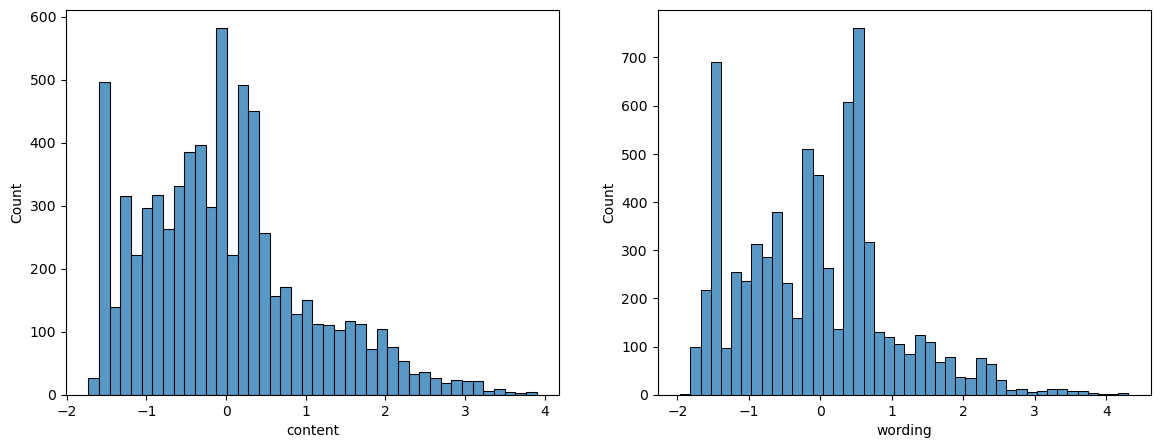

In [4]:
plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=summaries_train, x='content')
plt.subplot(1, 2, 2)
sns.histplot(data=summaries_train, x='wording')
plt.show()

# 4. Feature Engineering

In [5]:
def clean_text(text: str) -> str:
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

def count_total_words(text: str) -> int:
    words = text.split()
    total_words = len(words)
    return total_words

def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: count_total_words(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [6]:
summaries_train = feature_engineer(summaries_train)
summaries_test = feature_engineer(summaries_test)

In [7]:
vectorizer = TfidfVectorizer(encoding='utf-8',
                             ngram_range=(1, 1),
                             lowercase=True,
                             stop_words=list(stopwords.words('english')),
                             max_features=250)

train_vectorized = pd.DataFrame(
                vectorizer.fit_transform(summaries_train['text']).toarray(),
                columns=[f"tfidf_{str(f)}" for f in vectorizer.get_feature_names_out()],
            )

test_vectorized = pd.DataFrame(
                vectorizer.transform(summaries_test['text']).toarray(),
                columns=[f"tfidf_{str(f)}" for f in vectorizer.get_feature_names_out()],
            )

summaries_train = pd.concat([summaries_train, train_vectorized], axis=1)

summaries_test = pd.concat([summaries_test, test_vectorized], axis=1)

summaries_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  text_length  text_word_cnt  text_stopword_cnt  \
0  0.205683  0.380538          346             61                 25   
1 -0.548304  0.506755          244             52                 30   
2  3.128928  4.231226         1370            235                 98   
3 -0.210614 -0.471415          157             25                 11   
4  3.272894  3.219757         1225            203                 92   

   text_punct_cnt  text_number_cnt  ...  tfidf_well  tfidf_whenever  \
0               3                0  ...    0.000000             0.0   
1               2                0  ...    0.000000             0.0   
2              38                0  ...    0.089862             0.0   
3               6                2  ...    0.000000             0.0   
4              30                3  ...    0.000000             0.0   

   tfidf_white  tfidf_whole  tfidf_work  tfidf_worked  tfidf_workers  \
0          0.0          0.0    0.000000           0.0       0.000000   
1          0.0          0.0    0.000000           0.0       0.252892   
2          0.0          0.0    0.091531           0.0       0.090915   
3          0.0          0.0    0.000000           0.0       0.000000   
4          0.0          0.0    0.000000           0.0       0.000000   

   tfidf_working  tfidf_would  tfidf_write  
0            0.0     0.000000     0.000000  
1            0.0     0.425880     0.000000  
2            0.0     0.306210     0.116408  
3            0.0     0.000000     0.000000  
4            0.0     0.159293     0.000000  

[5 rows x 260 columns]

In [8]:
features = summaries_train.drop(columns = ['student_id', 'prompt_id', 'text', 'content', 'wording'], axis = 1).columns

# 5. Modeling

In [9]:
N_FOLDS = 10
SEED = 42
NUM_ROUNDS = 5000
EARLY_STOPPING_ROUNDS = 500
VERBOSE = 500

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'sampling_method': 'uniform',
    'tree_method': 'gpu_hist',
    'learning_rate': 0.008,
    'max_depth': 6,
    'subsample': 0.78,
    'min_child_weight': 5
    
}

for target in ['content', 'wording']:
    X = summaries_train[features]
    y = summaries_train[target]
    X_test = summaries_test[features]
    y_test = np.zeros(shape=summaries_test.shape[0], dtype=float)
    dtest = xgb.DMatrix(data=X_test)
    
    cv = KFold(n_splits = N_FOLDS, shuffle = True, random_state = SEED)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"| Target: {target} - Fold {idx+1} |".center(80, "-"))
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        print(f'train: {X_train.shape}')
        print(f'val: {X_val.shape}')
        dtrain = xgb.DMatrix(data=X_train, label=y_train)
        dval = xgb.DMatrix(data=X_val, label=y_val)
        
        model = xgb.train(params=params,
                          dtrain=dtrain,
                          evals=[(dtrain, 'train'), (dval, 'validation')],
                          num_boost_round=NUM_ROUNDS,
                          early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                          verbose_eval=VERBOSE)
        
        y_test += model.predict(dtest) / N_FOLDS
    sample_submission[target] = y_test

--------------------------| Target: content - Fold 1 |--------------------------
train: (6448, 255)
val: (717, 255)
[0]	train-rmse:1.15490	validation-rmse:1.16615
[500]	train-rmse:0.38512	validation-rmse:0.46151
[1000]	train-rmse:0.33666	validation-rmse:0.44807
[1500]	train-rmse:0.30922	validation-rmse:0.44431
[2000]	train-rmse:0.28824	validation-rmse:0.44270
[2500]	train-rmse:0.27011	validation-rmse:0.44219
[2741]	train-rmse:0.26203	validation-rmse:0.44237
--------------------------| Target: content - Fold 2 |--------------------------
train: (6448, 255)
val: (717, 255)
[0]	train-rmse:1.15622	validation-rmse:1.15376
[500]	train-rmse:0.38420	validation-rmse:0.46781
[1000]	train-rmse:0.33784	validation-rmse:0.45144
[1500]	train-rmse:0.30992	validation-rmse:0.44590
[2000]	train-rmse:0.28876	validation-rmse:0.44311
[2500]	train-rmse:0.27109	validation-rmse:0.44139
[3000]	train-rmse:0.25611	validation-rmse:0.44096
[3500]	train-rmse:0.24237	validation-rmse:0.44048
[4000]	train-rmse:0.23019	

In [10]:
sample_submission

student_id   content   wording
0  000000ffffff -1.634779 -1.571156
1  111111eeeeee -1.634779 -1.571156
2  222222cccccc -1.634779 -1.571156
3  333333dddddd -1.634779 -1.571156

In [11]:
sample_submission.to_csv('submission.csv', index=False)